In [48]:
import ast
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from collections import defaultdict
from os.path import join
from comm_data import PreprocessedCommData

import sys
sys.path.append("..")

from seal.trainer.communication import *

LOOSELY_DASHED = (0, (5, 10))
custom_params = {
    "axes.grid": True,
    # "axes.grid.linestyle": LOOSELY_DASHED,
    # "axes.grid.which": "both",
    "axes.spines.top": True,
    "axes.spines.right": True, 
    "axes.spines.top": True,
    "axes.spines.top": True,
}
sns.set_style("ticks", custom_params)

In [8]:
paths = []
dfs = []
for intersection in ["grid-3x3"]:
    for ranked in [True, False]:
        ranked_str = "ranked" if ranked else "unranked"
        paths.extend([
            join("..", "out", "data", "FedRL", intersection, f"v3_neg-reward-aggr_{ranked_str}.csv"),
            join("..", "out", "data", "FedRL", intersection, f"v3_traffic-aggr_{ranked_str}.csv"),
            join("..", "out", "data", "MARL",  intersection, f"v3_{ranked_str}.csv"),
            join("..", "out", "data", "SARL",  intersection, f"v3_{ranked_str}.csv")
        ])
        dfs.extend([
            PreprocessedCommData.preprocess(path, ranked=ranked, is_sarl="SARL" in path)
            for path in paths
        ])

df = pd.concat(dfs)
df.reset_index(inplace=True)
df.head()
# pre_df = PreprocessedCommData.preprocess(df, ranked=True)
# pre_df.head()

,index,round,timesteps_total,trainer,iteration,ranked,weight_aggr_fn,episode_reward_mean,policy_reward,comm_type,comm_cost,total_comm_cost
0,0,0,4000,FedRL,1,True,neg_reward,-25.735379,-0.519769,tls-to-edge-policy-comms,1,461330
1,1,0,4000,FedRL,1,True,neg_reward,-25.735379,-0.402553,tls-to-edge-policy-comms,1,461330
2,2,0,4000,FedRL,1,True,neg_reward,-25.735379,-0.543459,tls-to-edge-policy-comms,1,461330
3,3,0,4000,FedRL,1,True,neg_reward,-25.735379,-0.347775,tls-to-edge-policy-comms,1,461330
4,4,0,4000,FedRL,1,True,neg_reward,-25.735379,-0.380624,tls-to-edge-policy-comms,1,461330


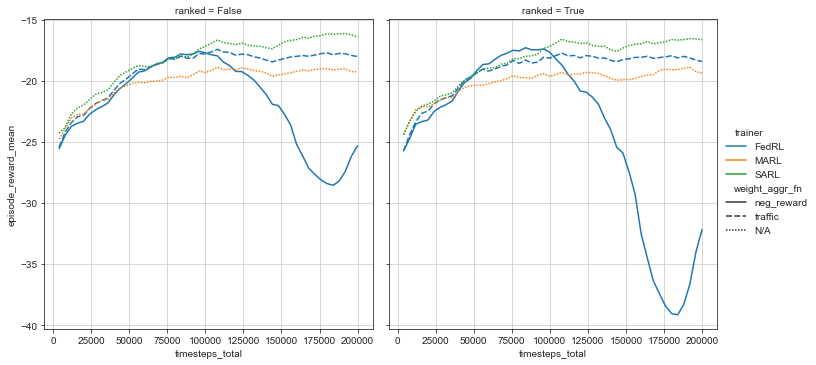

In [49]:
f = sns.relplot(data=df, kind="line", x="timesteps_total", y="episode_reward_mean", hue="trainer", style="weight_aggr_fn", col="ranked", ci=None)
sns.despine(top=False, right=False, left=False, bottom=False)
plt.savefig("rewards.pdf")
# plt.grid(linestyle=LOOSELY_DASHED)
# plt.title("Episode Reward Mean")
plt.show()

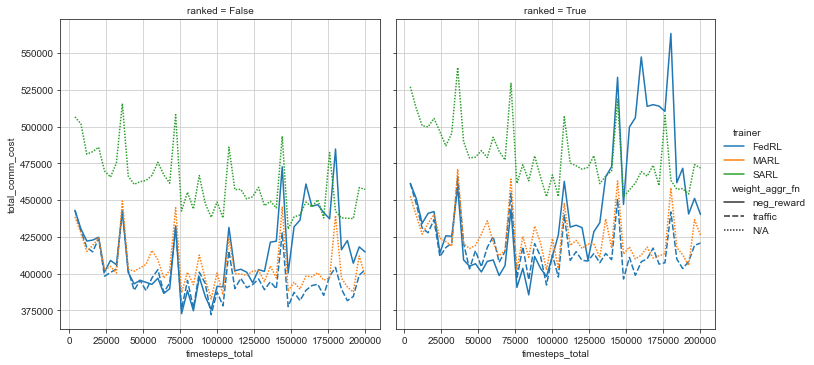

In [47]:
f = sns.relplot(data=df, kind="line", x="timesteps_total", y="total_comm_cost", hue="trainer", style="weight_aggr_fn", col="ranked", ci=None)
sns.despine(top=False, right=False, left=False, bottom=False)
plt.savefig("comm_cost.pdf")
# plt.grid(linestyle=LOOSELY_DASHED)
plt.show()

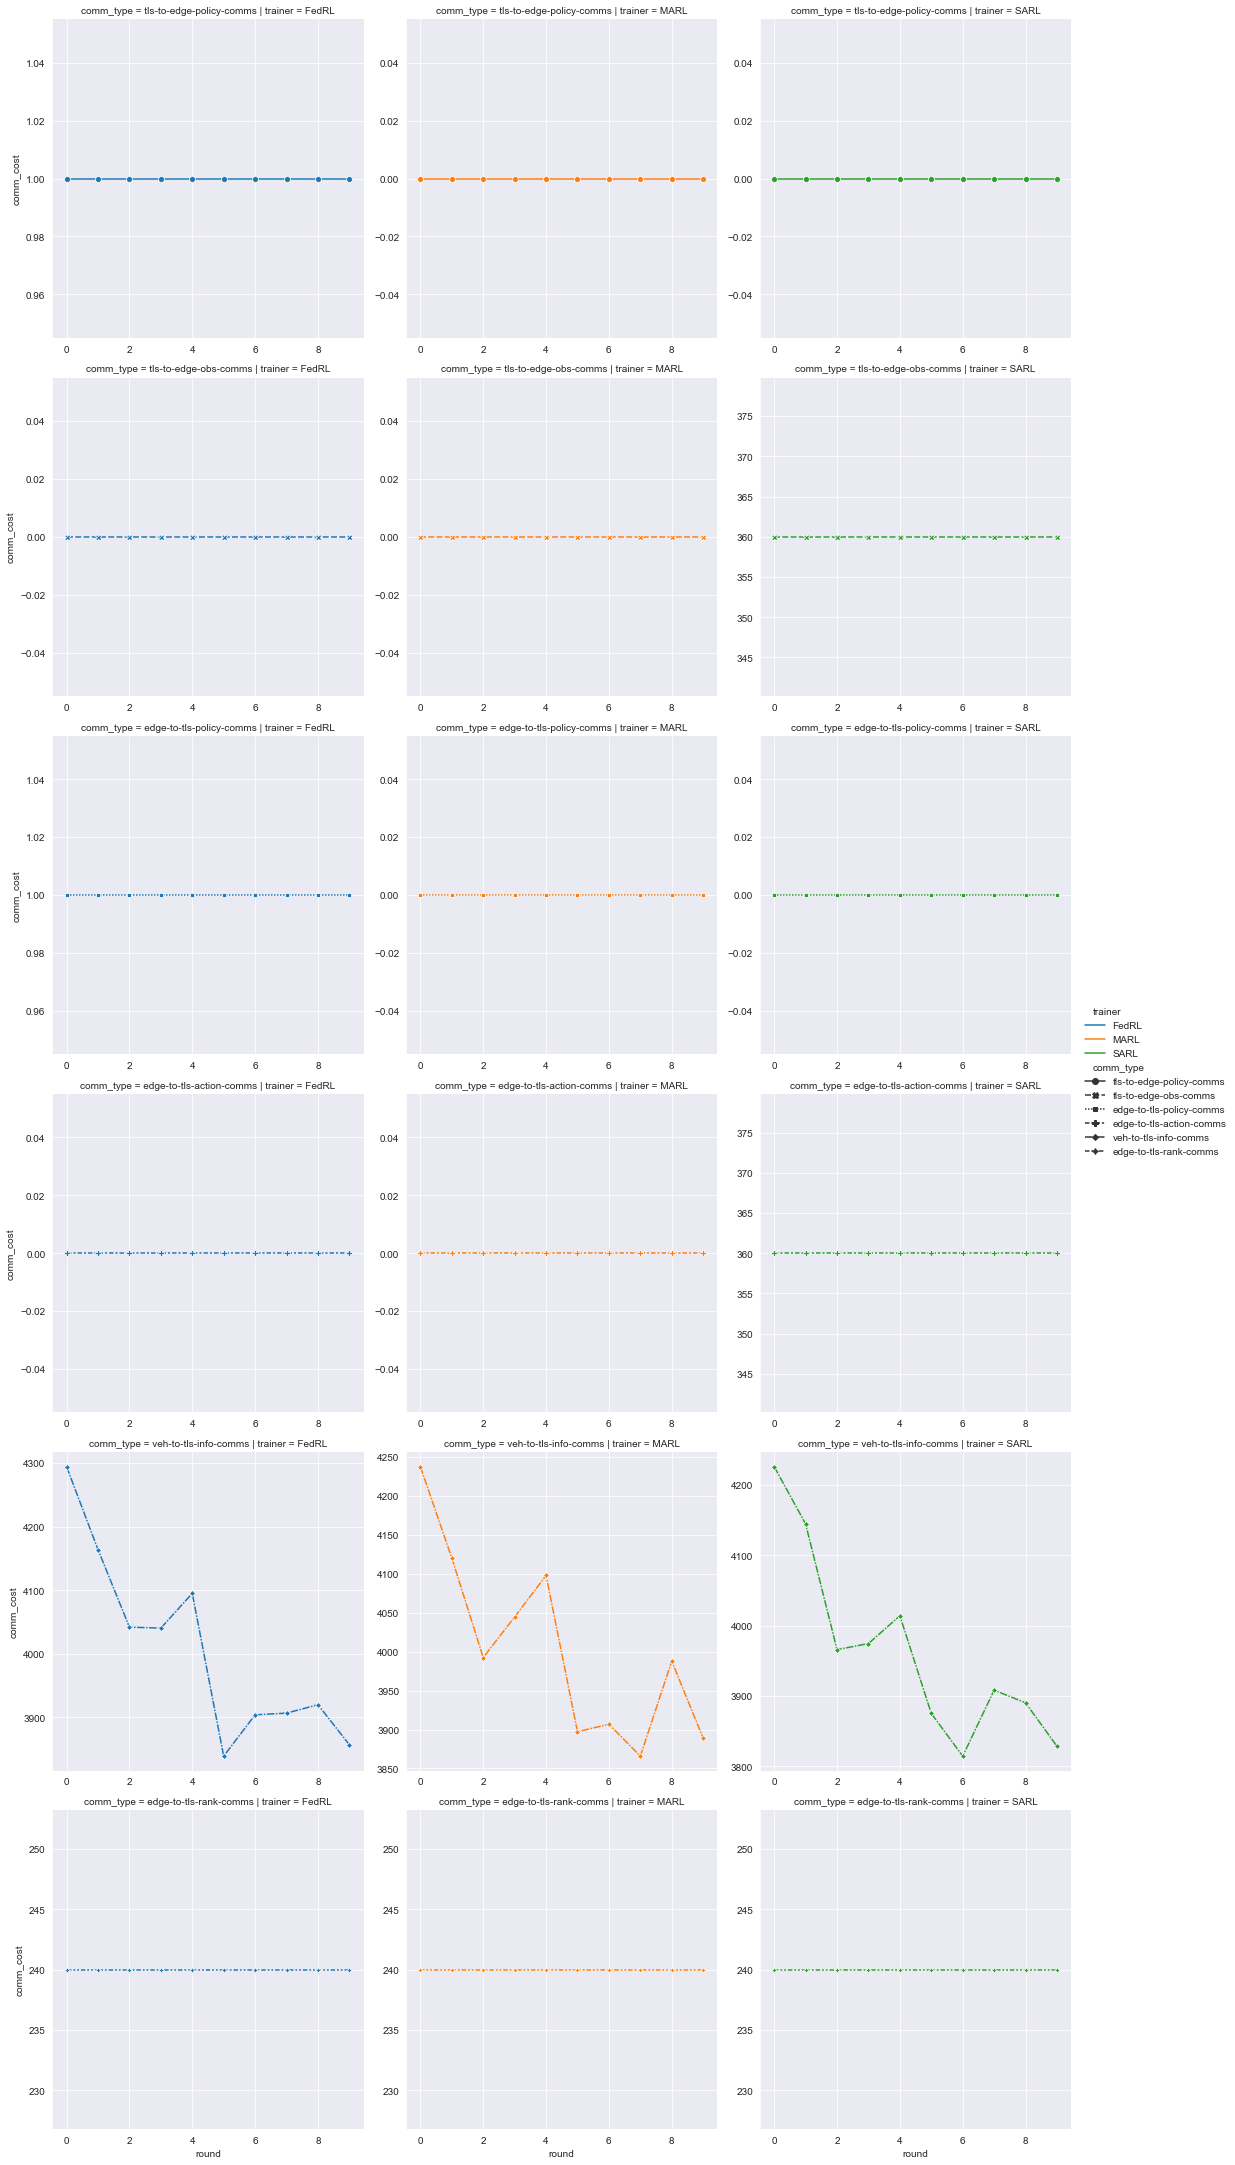

In [21]:
sns.relplot(
    data=df.query("round < 10"), 
    kind="line", 
    x="round", 
    y="comm_cost", 
    style="comm_type", 
    row="comm_type", 
    col="trainer",
    hue="trainer",
    markers=True,
    facet_kws={"sharex": False, "sharey": False},
    ci=None
)
plt.show()